# TP - Classification d'images médicales avec CNN et Transfert d’apprentissage

## Étape 1 : Préparation de l’environnement

### 1.1 Importer les bibliothèques nécessaires

In [69]:
# Bibliothèques principales pour la manipulation des données
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Bibliothèques PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Bibliothèques pour l’évaluation
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

### 1.2 Vérification de l’utilisation du GPU

In [72]:
# Vérifie si un GPU est disponible sinon utilise le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil utilisé :", device)

Appareil utilisé : cpu


## Étape 2 : Chargement et visualisation des données

### 2.1 Définir les transformations (Data Augmentation + Normalisation)

In [76]:
# Pour l'entraînement : on applique des augmentations pour améliorer la robustesse du modèle
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),     # effet miroir aléatoire
    transforms.RandomRotation(10),         # rotation aléatoire jusqu’à 10°
    transforms.ToTensor(),                 # conversion en tenseur
    transforms.Normalize([0.485, 0.456, 0.406],  # normalisation basée sur ImageNet
                         [0.229, 0.224, 0.225])
])

# Pour le test : on garde juste le redimensionnement et la normalisation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


### 2.2 Charger les jeux d’images avec ImageFolder

In [79]:
# Chemins vers les dossiers d'images
data_dir = "C:/Users/medmo/Data_classification_CNN/data"

# Chargement des datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Affichage des noms de classes
class_names = train_dataset.classes
print("Classes disponibles :", class_names)

Classes disponibles : ['benign', 'malignant']


### 2.3 Affichage de quelques images d’entraînement

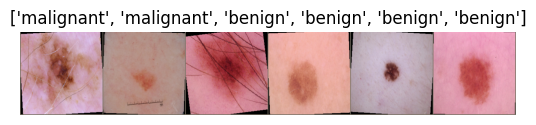

In [82]:
# Fonction pour afficher une image avec dés-normalisation
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Affichage d'un batch d’images
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs[:6])
imshow(out, title=[class_names[i] for i in classes[:6]])

### Question : Pourquoi applique-t-on des transformations différentes pour les images d'entraînement et celles de test ?

### Réponse :
- Les transformations appliquées sur les images d'entraînement (comme la rotation ou le miroir) permettent 
- d’augmenter artificiellement la taille et la diversité du dataset pour éviter l’overfitting.
- Pour les images de test, on ne veut pas de transformations aléatoires. On veut seulement normaliser
- les images pour que l’évaluation soit cohérente et représentative.

## Étape 3 : Implémentation d’un CNN personnalisé (convolutional neural network)

### Objectif de cette étape :
Créer un modèle CNN simple en partant de zéro, adapté à la classification d’images médicales.
Nous allons :
1. Définir une architecture personnalisée (Conv + ReLU + Pool + FC)
2. Choisir la fonction de perte
3. Configurer l’optimiseur

### 3.1 Définition du modèle CNN personnalisé

In [88]:
# Modèle CNN personnalisé
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Couche 1 : Convolution 3x3 -> ReLU -> MaxPool
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Couche 2 : Convolution 3x3 -> ReLU -> MaxPool
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Couche 3 : Convolution 3x3 -> ReLU -> MaxPool
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # 224 / 2 / 2 / 2 = 28
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Création du modèle
num_classes = len(class_names)
model = CustomCNN(num_classes).to(device)
print("Modèle créé avec succès")

Modèle créé avec succès


### 3.2 Définir la fonction de perte et l’optimiseur

In [91]:
# Fonction de perte (cross-entropy adaptée pour la classification multi-classes)
criterion = nn.CrossEntropyLoss()

# Optimiseur (Adam généralement efficace pour ce genre de tâche)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Question : Pourquoi la fonction de perte CrossEntropyLoss est-elle utilisée ici ?

### Réponse :
- La fonction CrossEntropyLoss est adaptée pour les tâches de classification multi-classes.
- Elle combine log_softmax et negative log likelihood en une seule fonction efficace,
- ce qui permet au modèle d’apprendre à prédire correctement la probabilité de chaque classe.

## Étape 4 : Entraînement du modèle avec métriques d’évaluation adaptées

### 4.1 Fonction d'entraînement (train) et d’évaluation (validate)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import time

# Fonction d'entraînement
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"\n Époque {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Entraînement", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Perte d'entraînement : {epoch_loss:.4f}")

        # Évaluation sur validation
        validate_model(model, val_loader, device)

### 4.2 Fonction d’évaluation : métriques médicales (précision, rappel, F1…)

In [99]:
def validate_model(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Rapport de classification
    print("\n Rapport de classification (validation) :")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()

### 4.3 Lancer l'entraînement

In [111]:
# Création de val_loader

from torch.utils.data import random_split, DataLoader

# Supposons que 'train_dataset' est déjà défini
# On réserve 80% pour l'entraînement, 20% pour la validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


 Époque 1/10


Perte d'entraînement : 0.6449

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.93      0.61      0.74       282
   malignant       0.68      0.94      0.79       246

    accuracy                           0.77       528
   macro avg       0.80      0.78      0.76       528
weighted avg       0.81      0.77      0.76       528



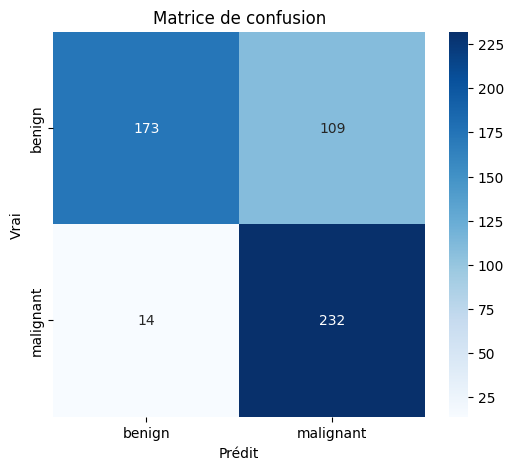


 Époque 2/10


Perte d'entraînement : 0.4146

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.88      0.70      0.78       282
   malignant       0.72      0.89      0.80       246

    accuracy                           0.79       528
   macro avg       0.80      0.80      0.79       528
weighted avg       0.81      0.79      0.79       528



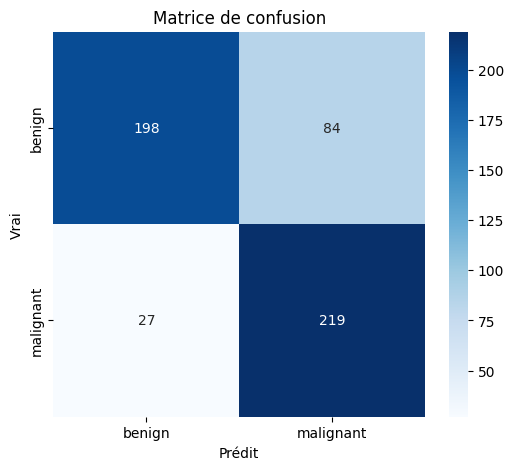


 Époque 3/10


Perte d'entraînement : 0.4070

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.91      0.64      0.75       282
   malignant       0.69      0.93      0.79       246

    accuracy                           0.77       528
   macro avg       0.80      0.78      0.77       528
weighted avg       0.81      0.77      0.77       528



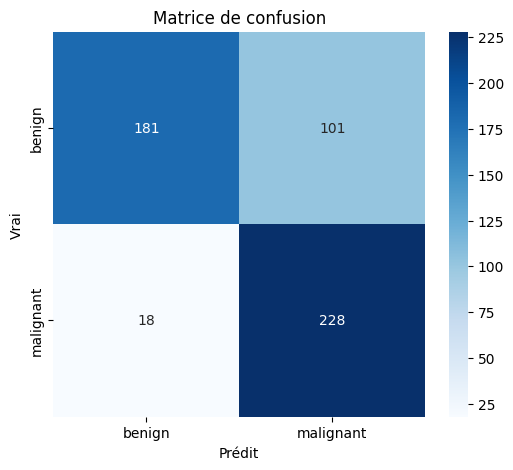


 Époque 4/10


Perte d'entraînement : 0.3846

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.93      0.66      0.77       282
   malignant       0.71      0.94      0.81       246

    accuracy                           0.79       528
   macro avg       0.82      0.80      0.79       528
weighted avg       0.83      0.79      0.79       528



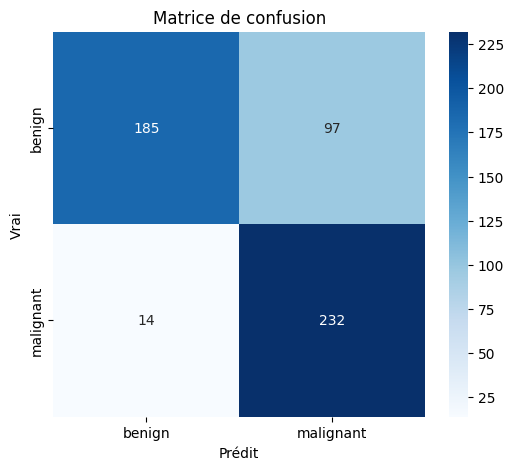


 Époque 5/10


Perte d'entraînement : 0.3603

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.91      0.70      0.79       282
   malignant       0.73      0.92      0.81       246

    accuracy                           0.80       528
   macro avg       0.82      0.81      0.80       528
weighted avg       0.82      0.80      0.80       528



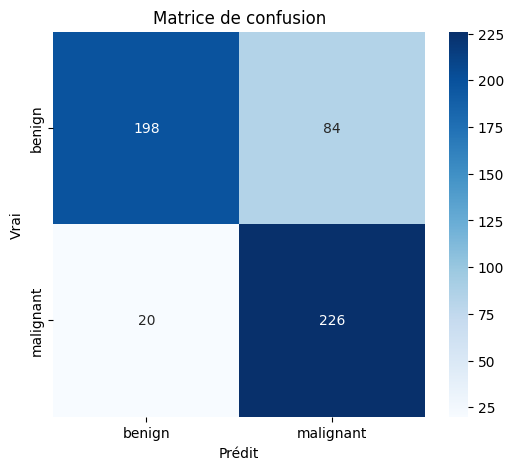


 Époque 6/10


Perte d'entraînement : 0.3586

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.85      0.80      0.82       282
   malignant       0.78      0.84      0.81       246

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.82      0.82      0.82       528



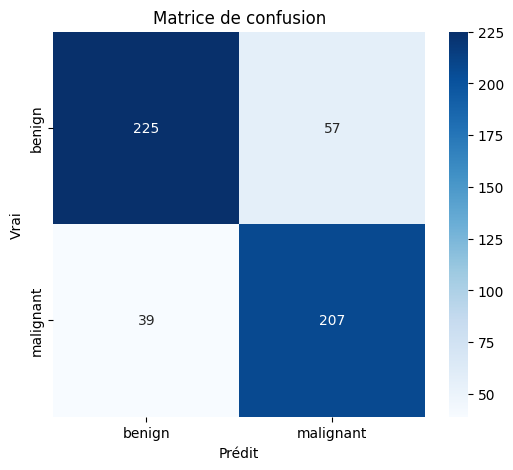


 Époque 7/10


Perte d'entraînement : 0.3521

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.88      0.77      0.82       282
   malignant       0.77      0.88      0.82       246

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.83      0.82      0.82       528



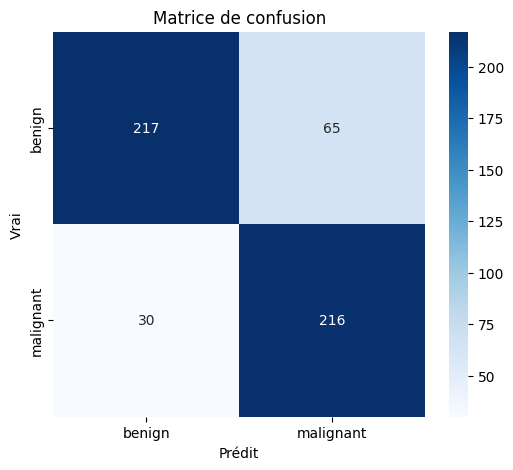


 Époque 8/10


Perte d'entraînement : 0.3393

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.90      0.73      0.81       282
   malignant       0.75      0.91      0.82       246

    accuracy                           0.81       528
   macro avg       0.82      0.82      0.81       528
weighted avg       0.83      0.81      0.81       528



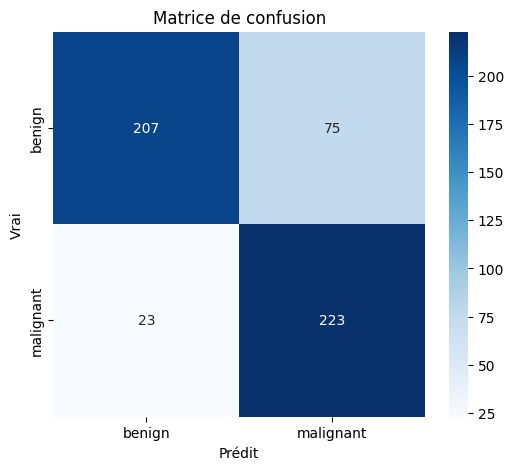


 Époque 9/10


Perte d'entraînement : 0.3354

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.89      0.75      0.81       282
   malignant       0.76      0.90      0.82       246

    accuracy                           0.82       528
   macro avg       0.83      0.82      0.82       528
weighted avg       0.83      0.82      0.82       528



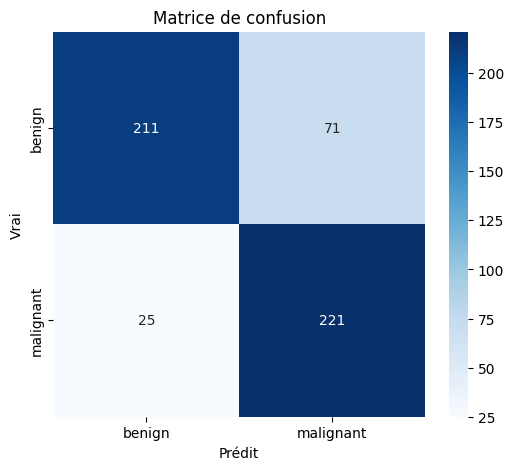


 Époque 10/10


Perte d'entraînement : 0.3353

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.85      0.79      0.82       282
   malignant       0.78      0.84      0.81       246

    accuracy                           0.82       528
   macro avg       0.82      0.82      0.82       528
weighted avg       0.82      0.82      0.82       528



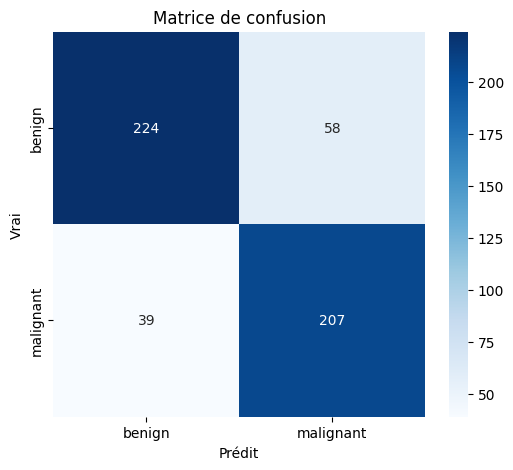

In [109]:
# Entraînement du modèle
train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

### Pourquoi ces métriques ?
En contexte médical, il ne suffit pas d'avoir une bonne "accuracy".
On doit surtout analyser :
- la "sensibilité" (Recall) → éviter les faux négatifs (ne pas rater une maladie)
- la "spécificité" → éviter les faux positifs (ne pas alarmer à tort)
- la "valeur prédictive positive" (PPV)
- le "F1-score" qui équilibre précision et rappel

## Étape 5 : Gestion du déséquilibre avec une perte pondérée (Weighted Loss)

Objectif :Lorsque les classes sont déséquilibrées (ex: 90% classe 0, 10% classe 1), le modèle aura tendance à ignorer la classe minoritaire. Pour corriger cela, on pondère la fonction de perte selon la fréquence des classes.

### 5.1 Calcul des poids inverses en fonction de la fréquence des classes

In [122]:
from collections import Counter
import torch

# Supposons que vous avez une liste de labels
labels_list = [label for _, label in train_dataset]  # train_dataset est un Dataset PyTorch
class_counts = Counter(labels_list)

# Nombre total d'échantillons
total_samples = sum(class_counts.values())

# Calcul du poids inversement proportionnel à la fréquence
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}

# Conversion en tensor (attention à l'ordre des classes !)
weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float).to(device)


### 5.2 Utilisation avec nn.CrossEntropyLoss

In [124]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=weights)


### Exemple complet intégré dans l'entraînement :


 Époque 1/10


Perte d'entraînement : 0.3229

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.90      0.83      0.87       296
   malignant       0.81      0.88      0.84       232

    accuracy                           0.86       528
   macro avg       0.85      0.86      0.86       528
weighted avg       0.86      0.86      0.86       528



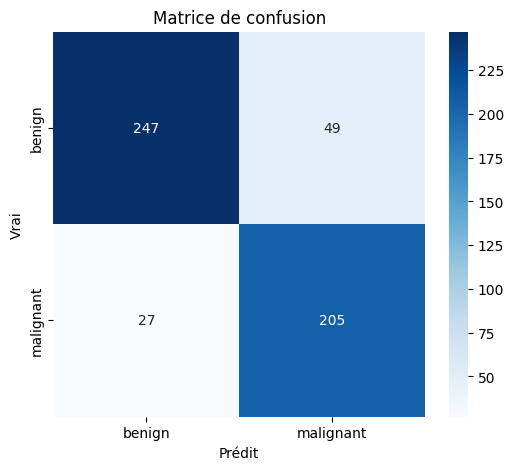


 Époque 2/10


Perte d'entraînement : 0.3023

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.95      0.77      0.85       296
   malignant       0.76      0.95      0.84       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



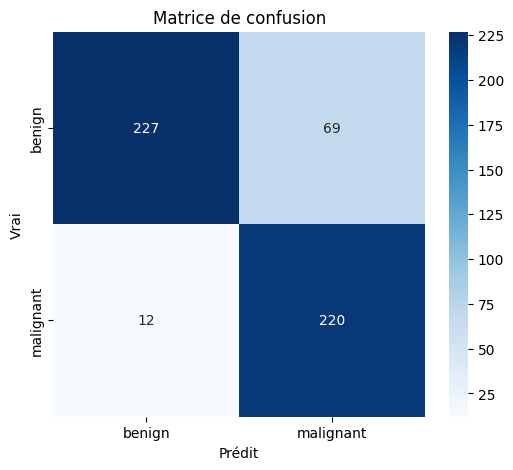


 Époque 3/10


Perte d'entraînement : 0.2959

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.95      0.79      0.86       296
   malignant       0.78      0.94      0.85       232

    accuracy                           0.86       528
   macro avg       0.86      0.87      0.86       528
weighted avg       0.87      0.86      0.86       528



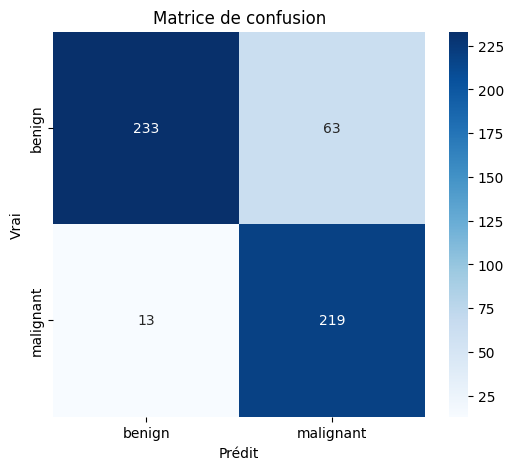


 Époque 4/10


Perte d'entraînement : 0.2926

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.94      0.77      0.85       296
   malignant       0.76      0.94      0.84       232

    accuracy                           0.84       528
   macro avg       0.85      0.85      0.84       528
weighted avg       0.86      0.84      0.84       528



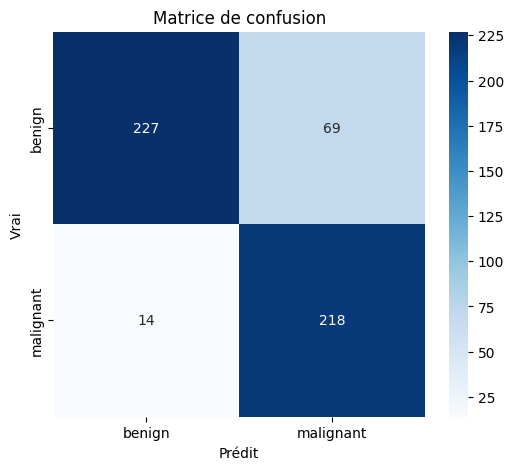


 Époque 5/10


Perte d'entraînement : 0.2894

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.92      0.81      0.86       296
   malignant       0.79      0.91      0.85       232

    accuracy                           0.85       528
   macro avg       0.85      0.86      0.85       528
weighted avg       0.86      0.85      0.85       528



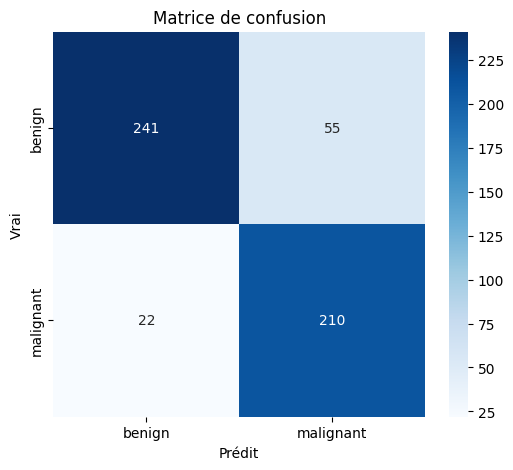


 Époque 6/10


Perte d'entraînement : 0.2878

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.94      0.78      0.85       296
   malignant       0.77      0.94      0.85       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



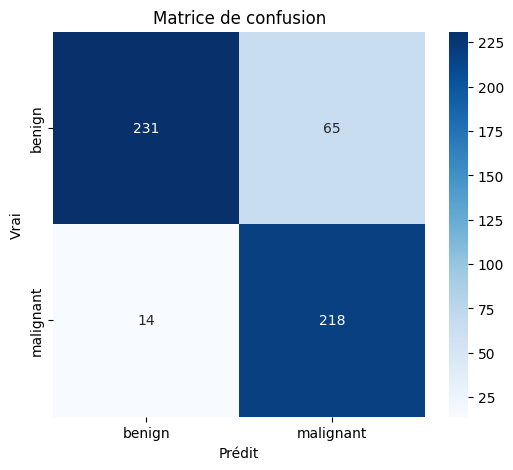


 Époque 7/10


Perte d'entraînement : 0.2544

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.95      0.78      0.85       296
   malignant       0.77      0.94      0.85       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



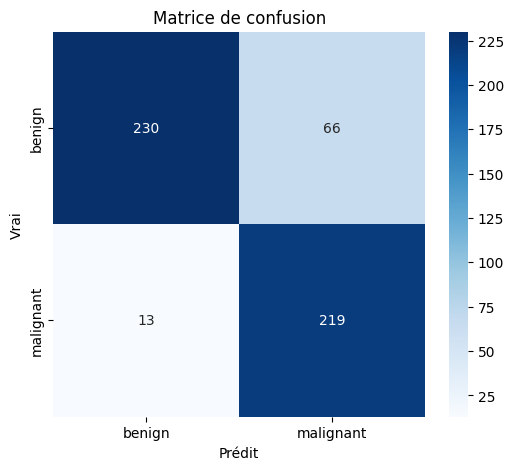


 Époque 8/10


Perte d'entraînement : 0.2569

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.89      0.79      0.84       296
   malignant       0.77      0.88      0.82       232

    accuracy                           0.83       528
   macro avg       0.83      0.83      0.83       528
weighted avg       0.84      0.83      0.83       528



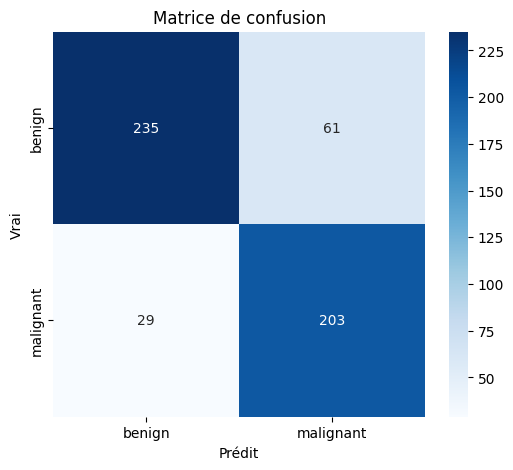


 Époque 9/10


Perte d'entraînement : 0.2389

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.85      0.88      0.86       296
   malignant       0.84      0.80      0.82       232

    accuracy                           0.84       528
   macro avg       0.84      0.84      0.84       528
weighted avg       0.84      0.84      0.84       528



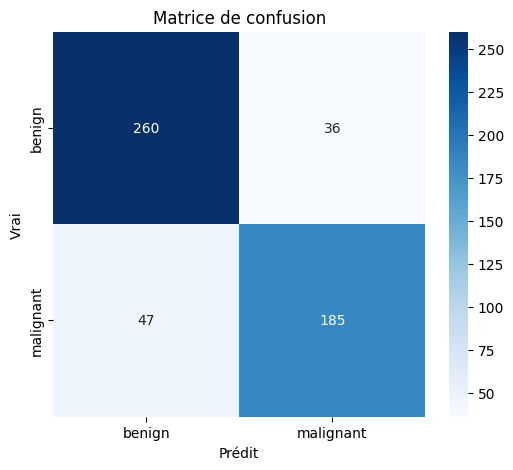


 Époque 10/10


Perte d'entraînement : 0.2348

 Rapport de classification (validation) :
              precision    recall  f1-score   support

      benign       0.96      0.79      0.87       296
   malignant       0.78      0.96      0.86       232

    accuracy                           0.87       528
   macro avg       0.87      0.88      0.87       528
weighted avg       0.88      0.87      0.87       528



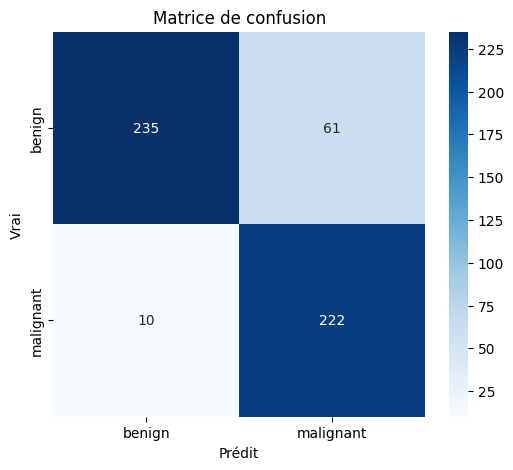

In [126]:
# Calcul des poids une seule fois
from collections import Counter

labels_list = [label for _, label in train_dataset]
class_counts = Counter(labels_list)
total_samples = sum(class_counts.values())
weights = torch.tensor(
    [total_samples / class_counts[i] for i in range(len(class_counts))],
    dtype=torch.float
).to(device)

# Nouvelle fonction de perte pondérée
criterion = nn.CrossEntropyLoss(weight=weights)

# Entraînement comme avant
train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)


### Vérification facultative :
- Tu peux imprimer weights pour vérifier que la classe minoritaire a un poids plus grand.
- Tu peux aussi afficher une matrice de confusion après entraînement pour valider que les classes rares sont mieux détectées.

## Étape 6 : Sauvegarde et Chargement du Modèle

### 6.1 Sauvegarder le modèle

In [132]:
# 📌 Sauvegarde du modèle entraîné
model_path = "mon_model_cnn.pth"
torch.save(model.state_dict(), model_path)

print(f"Modèle sauvegardé dans : {model_path}")


Modèle sauvegardé dans : mon_model_cnn.pth


### 6.2 Recharger le modèle ultérieurement


In [134]:
# 🔁 Redéfinir l'architecture (même structure que celle utilisée lors de l'entraînement)
model = CustomCNN(num_classes=num_classes)
model.load_state_dict(torch.load("mon_model_cnn.pth"))
model.eval()  # mode évaluation

print("Modèle chargé avec succès.")


Modèle chargé avec succès.


## Étape 7 : Inférence sur de nouvelles images

### 7.1 Fonction d'inférence sur une image unique

In [160]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def prédire_image(image_path, model, device, class_names):
    """
    Fonction pour charger une image, l'appliquer les mêmes transformations,
    la passer au modèle et afficher la prédiction.
    """
    # Transforms identiques à celles du DataLoader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Chargement de l'image  
    image = Image.open(image_path).convert("RGB")  
    image_tensor = transform(image).unsqueeze(0).to(device)  
    
    # Mode évaluation  
    model.eval()  
    with torch.no_grad():  
        outputs = model(image_tensor)  
        _, predicted = torch.max(outputs, 1)  
    
    classe_prévue = class_names[predicted.item()]  
    print(f"Classe prédite : {classe_prévue}")  
    return classe_prévue  

### 7.2 Utilisation de la fonction

In [162]:
image_path = "D:/image_test.jpg"
class_names = train_dataset.classes
prédire_image(image_path, model, device, class_names)

Classe prédite : malignant


'malignant'

## Étape 8 : Évaluation complète du modèle

#### Métriques à calculer :
1. Accuracy (Précision globale)
2. Précision (Precision)
3. Rappel (Recall / Sensibilité)
4. Spécificité
5. Score F1
6. Matrice de confusion
7. Valeur prédictive positive et négative
8. Courbe ROC + AUC

### 8.1 Récupération des prédictions et labels

In [164]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def évaluer_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


### 8.2 Rapport de classification & matrice de confusion

Rapport de classification :
              precision    recall  f1-score   support

      benign       0.95      0.78      0.86       296
   malignant       0.77      0.94      0.85       232

    accuracy                           0.85       528
   macro avg       0.86      0.86      0.85       528
weighted avg       0.87      0.85      0.85       528



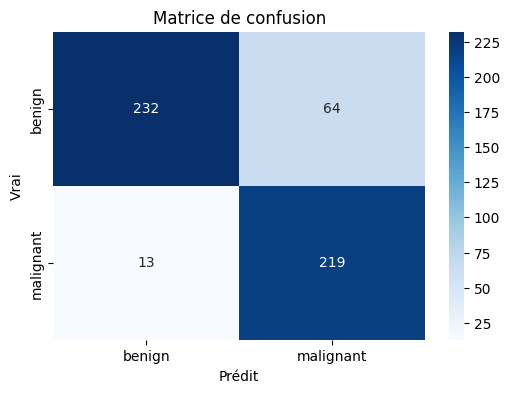

In [166]:
preds, labels, probs = évaluer_model(model, val_loader, device, class_names)

# Classification Report
print("Rapport de classification :")
print(classification_report(labels, preds, target_names=class_names))

# Matrice de confusion
plt.figure(figsize=(6, 4))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


### 8.3 Métriques supplémentaires (spécificité, VPP, VPN…)

In [168]:
# Calcul manuel de la spécificité, VPP et VPN (pour binaire uniquement)
if len(class_names) == 2:
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    sensibilité = tp / (tp + fn)
    spécificité = tn / (tn + fp)
    vpp = tp / (tp + fp)
    vpn = tn / (tn + fn)
    
    print(f"Sensibilité : {sensibilité:.2f}")
    print(f"Spécificité : {spécificité:.2f}")
    print(f"Valeur Prédictive Positive (VPP) : {vpp:.2f}")
    print(f"Valeur Prédictive Négative (VPN) : {vpn:.2f}")


Sensibilité : 0.94
Spécificité : 0.78
Valeur Prédictive Positive (VPP) : 0.77
Valeur Prédictive Négative (VPN) : 0.95


### 8.4 Courbe ROC et AUC

(binaire uniquement)

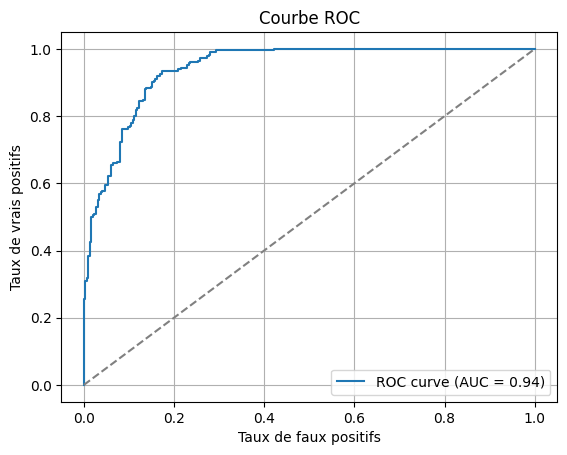

In [205]:
if len(class_names) == 2:
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    auc = roc_auc_score(labels, probs[:, 1])

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)
    plt.show()